In [7]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import os
from PIL import Image
import matplotlib.pyplot as plt


6 frog
<PIL.Image.Image image mode=RGB size=32x32 at 0x7FB866FF26D0>
50000


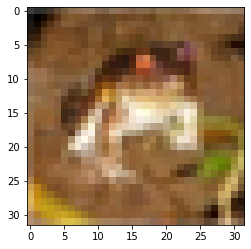

In [8]:
train_dataset = CIFAR10(root = os.getcwd(),train = True)

image,label = train_dataset[0]
classes = ['plane','car','bird','cat','deer',
'dog','frog','horse','ship','truck']

print(label,classes[label])
print(image)
plt.imshow(image)
print(len(train_dataset))

In [9]:
train_ds = CIFAR10(root = os.getcwd(),
                        train = True,
                        transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                    )

train_dataset, val_dataset = random_split(train_ds,[40000,10000])

train_loader = DataLoader(train_dataset,batch_size = 200,shuffle = True)

val_loader = DataLoader(val_dataset,batch_size = 200,shuffle = True)


test_dataset = CIFAR10(root = os.getcwd(),
                        train = False,
                        transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
                                    )
                                    
test_loader = DataLoader(test_dataset,batch_size = 200,shuffle = True)

In [10]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,
                               out_channels = 32,
                               kernel_size = 3,
                               padding= 1,
                               bias=True)
        self.norm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 32,
                               kernel_size = 3,
                               padding= 1,
                               bias=True)
        self.norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               padding= 1,
                               bias=True)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(in_channels = 64,
                               out_channels = 64,
                               kernel_size = 3,
                               padding= 1,
                               bias=True)
        self.norm4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(in_features = 64*2*2,
                             out_features = 120)
        self.norm5 = nn.BatchNorm1d(120)

        self.fc2 = nn.Linear(in_features = 120,
                             out_features = 120)
        self.norm6 = nn.BatchNorm1d(120)

        self.fc3 = nn.Linear(in_features = 120,
                             out_features = 10)
                             
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.4)

    def forward(self,x):
        #print('1st conv before conv',x.shape)
        x = self.norm1(self.relu(self.conv1(x)))
        #print('1st conv after conv and before pool',x.shape)
        x = self.pool(x)
        residual = x
        #print('2nd conv befor conv',x.shape)
        x = self.norm2(self.relu(self.conv2(x)))
        x+=residual
        #print('2nd conv after conv and before pool',x.shape)
        x = self.pool(x)
        #print('3rd conv befor conv',x.shape)
        x = self.norm3(self.relu(self.conv3(x)))
        #print('3rd conv after conv and before pool',x.shape)
        x = self.pool(x)
        residual = x
        #print('4th conv before conv',x.shape)
        x = self.norm4(self.relu(self.conv4(x)))
        x+=residual
        #print('4th conv after conv and before pool',x.shape)
        x = self.pool(x)
        #print('4th conv after pool',x.shape)
        x = torch.flatten(x,1)
        #print('x flattened ',x.shape)
        x = self.norm5(self.relu(self.dropout(self.fc1(x))))
        residual = x
        #print('After 1st fc',x.shape)
        x = self.norm6(self.relu(self.dropout(self.fc2(x))))
        x+=residual
        #print('After 2nd fc',x.shape)
        x = self.fc3(x)
        return x


In [11]:
def accuracy(lbl_pred,lbl_true):
    return torch.sum(lbl_pred==lbl_true) / len(lbl_pred)

In [12]:
from torch.nn.functional import cross_entropy,softmax
from torch.optim import SGD,Adam
import numpy as np

model = Network()
opt = SGD(model.parameters(),lr = 0.01,weight_decay= 0.007)

n_epochs = 40

train_scores = []
val_scores = []
min_valid_loss = np.inf 

for epoch in range(n_epochs):
    train_score = 0
    for images,labels in train_loader:
        opt.zero_grad()
        y_pred = model(images)
        probs = softmax(y_pred, dim = 1)
        max_probs, pred = torch.max(probs,dim =1)
        train_loss = cross_entropy(y_pred,labels)
        train_accuracy = accuracy(pred,labels)
        train_loss.backward()
        opt.step()
        train_score+=train_accuracy.item()

    model.eval()
    val_score = 0
    for img,lbl in val_loader:
        y_val = model(img)
        probs = softmax(y_val, dim = 1)
        _, pred = torch.max(probs,dim =1)
        val_loss = cross_entropy(y_val,lbl)
        val_accuracy = accuracy(pred,lbl)
        val_score+=val_accuracy.item()

    train_scores.append(train_score/len(train_loader))
    val_scores.append(val_score/len(val_loader))

    model.train()

    print(f'Train score {epoch+1}/{n_epochs}: {train_scores[-1]}')
    print(f'Validation score {epoch+1}/{n_epochs}: {val_scores[-1]}')

    if min_valid_loss > val_loss:
        min_valid_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Train loss 1/40: 0.3194499994814396
Validation loss 1/40: 0.4588999992609024
Train loss 2/40: 0.4449499996006489
Validation loss 2/40: 0.496599999666214
Train loss 3/40: 0.5034000000357628
Validation loss 3/40: 0.5516000002622604
Train loss 4/40: 0.5463499987125396
Validation loss 4/40: 0.5438999980688095
Train loss 5/40: 0.5738250006735325
Validation loss 5/40: 0.5902999967336655
Train loss 6/40: 0.6013250005245209
Validation loss 6/40: 0.5806000006198883
Train loss 7/40: 0.6229999989271164
Validation loss 7/40: 0.6388999998569489
Train loss 8/40: 0.6401750004291534
Validation loss 8/40: 0.6474999988079071
Train loss 9/40: 0.6551999989151954
Validation loss 9/40: 0.6512000000476837
Train loss 10/40: 0.6726500004529953
Validation loss 10/40: 0.6634000015258789
Train loss 11/40: 0.6850749996304512
Validation loss 11/40: 0.6795000016689301
Train loss 12/40: 0.7008500003814697
Validation loss 12/40: 0.673199999332428
Train loss 13/40: 0.7091999989748001
Validation loss 13/40: 0.6791000020

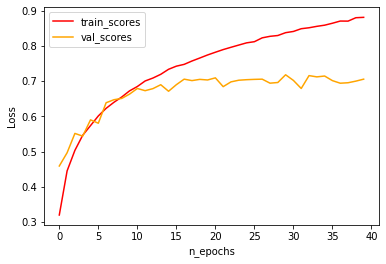

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(n_epochs),train_scores,c = 'red',label = 'train_scores')
plt.plot(range(n_epochs),val_scores,c = 'orange',label = 'val_scores')
plt.legend()
plt.xlabel('n_epochs')
plt.ylabel('Loss')

plt.show()

In [14]:
model = Network()
model.load_state_dict(torch.load('best_model.pth'))

score = 0
for images,labels in test_loader:
    y_pred = model(images)
    probs = softmax(y_pred, dim = 1)
    max_probs, pred = torch.max(probs,dim =1)
    accuracy_ = accuracy(pred,labels)
    score+=accuracy_
    print(f'Accuracy: {accuracy_}')
print(f'Mean accuracy: {score/len(test_loader)}')

Accuracy: 0.7450000047683716
Accuracy: 0.6850000023841858
Accuracy: 0.6600000262260437
Accuracy: 0.7200000286102295
Accuracy: 0.7250000238418579
Accuracy: 0.7099999785423279
Accuracy: 0.699999988079071
Accuracy: 0.7599999904632568
Accuracy: 0.6899999976158142
Accuracy: 0.7250000238418579
Accuracy: 0.6800000071525574
Accuracy: 0.6850000023841858
Accuracy: 0.6650000214576721
Accuracy: 0.7250000238418579
Accuracy: 0.7300000190734863
Accuracy: 0.7699999809265137
Accuracy: 0.6850000023841858
Accuracy: 0.6899999976158142
Accuracy: 0.6949999928474426
Accuracy: 0.6949999928474426
Accuracy: 0.6650000214576721
Accuracy: 0.7099999785423279
Accuracy: 0.6899999976158142
Accuracy: 0.6449999809265137
Accuracy: 0.6949999928474426
Accuracy: 0.6899999976158142
Accuracy: 0.7099999785423279
Accuracy: 0.6800000071525574
Accuracy: 0.6949999928474426
Accuracy: 0.7149999737739563
Accuracy: 0.7049999833106995
Accuracy: 0.6499999761581421
Accuracy: 0.7099999785423279
Accuracy: 0.7549999952316284
Accuracy: 0.720

In [16]:
from torch.optim import Adam
model = Network()
model.load_state_dict(torch.load('best_model.pth'))

opt = Adam(model.parameters(),lr = 0.00001,weight_decay=0.7)
n_epochs = 20

for epoch in range(n_epochs):
    train_score = 0
    for images,labels in train_loader:
        opt.zero_grad()
        y_pred = model(images)
        probs = softmax(y_pred, dim = 1)
        max_probs, pred = torch.max(probs,dim =1)
        train_loss = cross_entropy(y_pred,labels)
        train_accuracy = accuracy(pred,labels)
        train_loss.backward()
        opt.step()
        train_score+=train_accuracy.item()

    model.eval()
    val_score = 0
    for img,lbl in val_loader:
        y_val = model(img)
        probs = softmax(y_val, dim = 1)
        _, pred = torch.max(probs,dim =1)
        val_loss = cross_entropy(y_val,lbl)
        val_accuracy = accuracy(pred,lbl)
        val_score+=val_accuracy.item()

    train_scores.append(train_score/len(train_loader))
    val_scores.append(val_score/len(val_loader))

    model.train()

    #if (epoch+1) % 5 ==0:
    #print(f'Train accuracy {epoch+1}/{n_epochs} : {train_accuracy}')
    print(f'Train loss {epoch+1}/{n_epochs}: {train_scores[-1]}')
    #print(f'Validation accuracy {epoch+1}/{n_epochs} : {val_accuracy}')
    print(f'Validation loss {epoch+1}/{n_epochs}: {val_scores[-1]}')

    if min_valid_loss > val_loss:
        min_valid_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Train loss 1/20: 0.8901749980449677
Validation loss 1/20: 0.7343000030517578
Train loss 2/20: 0.9027499988675117
Validation loss 2/20: 0.7358000016212464


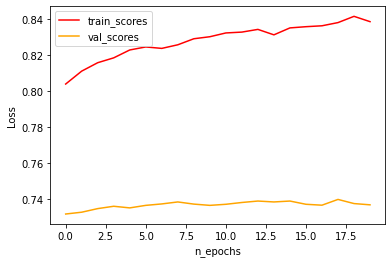

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(65),train_scores,c = 'red',label = 'train_scores')
plt.plot(range(65),val_scores,c = 'orange',label = 'val_scores')
plt.legend()
plt.xlabel('n_epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
model = Network()
model.load_state_dict(torch.load('best_model.pth'))

score = 0
for images,labels in test_loader:
    y_pred = model(images)
    probs = softmax(y_pred, dim = 1)
    max_probs, pred = torch.max(probs,dim =1)
    accuracy_ = accuracy(pred,labels)
    score+=accuracy_
    print(f'Accuracy: {accuracy_}')
print(f'Mean accuracy: {score/len(test_loader)}')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # 1st conv layer
            nn.Conv2d(in_channels = 3,
                      out_channels = 15,
                      kernel_size = 4,
                      padding= 2,
                      bias = True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(15),
            # 2nd conv layer
            nn.Conv2d(in_channels = 15,
                      out_channels = 30,
                      kernel_size = 4,
                      padding= 2,
                      bias = True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(30),
            # 3rd conv layer
            nn.Conv2d(in_channels = 30,
                      out_channels = 45,
                      kernel_size = 4,
                      padding= 1,
                      bias = True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(45),
            # 4th linear layer
            nn.Flatten(),
            nn.Linear(in_features = 45*3*3,
                      out_features = 100),
            nn.Dropout(p= 0.3),
            nn.ReLU(),
            # 5th linear layer
            nn.Linear(in_features = 100,
                      out_features = 50),
            nn.Dropout(p = 0.3),
            nn.ReLU(),
            nn.BatchNorm1d(50),
            # 6th linear layer
            nn.Linear(in_features = 50,
                      out_features = 10),
        )
    
    def forward(self,x):
        return self.network(x)